Visualizations and descriptive states
==============

In [1]:
# Create paths to pkl files
import os
project_root = os.path.abspath("..")
reg_path = os.path.join(project_root, "data", "processed", "clean_reg_data.pkl")
auth_path = os.path.join(project_root, "data", "processed", "clean_auth_data.pkl")
ab_path = os.path.join(project_root, "data", "processed", "clean_ab_test.pkl")

In [2]:
# Import library
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Read pkl files
df_reg_data = pd.read_pickle(reg_path)
df_auth_data = pd.read_pickle(auth_path)
df_ab_test = pd.read_pickle(ab_path)

In [4]:
print(df_reg_data.head(5))
print("===========")
print(df_auth_data.head(5))

                     reg_ts  uid
0 1998-11-18 09:43:43+00:00    1
1 1999-07-22 22:38:09+00:00    2
2 2000-01-13 22:27:27+00:00    3
3 2000-05-28 14:19:01+00:00    4
4 2000-09-16 11:21:53+00:00    5
                    auth_ts  uid
0 1998-11-18 09:43:43+00:00    1
1 1999-07-22 22:38:09+00:00    2
2 1999-07-25 16:46:46+00:00    2
3 1999-07-31 03:50:15+00:00    2
4 1999-08-05 17:49:39+00:00    2


At what days after registering do players usually log in?

In [5]:
# Merge the dataframes of registration and login data
df_reg_auth = pd.merge(df_reg_data, df_auth_data, on="uid", how="left")
df_reg_auth.head(5)

,reg_ts,uid,auth_ts
0,1998-11-18 09:43:43+00:00,1,1998-11-18 09:43:43+00:00
1,1999-07-22 22:38:09+00:00,2,1999-07-22 22:38:09+00:00
2,1999-07-22 22:38:09+00:00,2,1999-07-25 16:46:46+00:00
3,1999-07-22 22:38:09+00:00,2,1999-07-31 03:50:15+00:00
4,1999-07-22 22:38:09+00:00,2,1999-08-05 17:49:39+00:00


In [6]:
# How many days is it from players' registration date to the login date
df_reg_auth["elapsed_days"] = (df_reg_auth["auth_ts"] - df_reg_auth["reg_ts"]).dt.days
df_reg_auth.head(5)

,reg_ts,uid,auth_ts,elapsed_days
0,1998-11-18 09:43:43+00:00,1,1998-11-18 09:43:43+00:00,0
1,1999-07-22 22:38:09+00:00,2,1999-07-22 22:38:09+00:00,0
2,1999-07-22 22:38:09+00:00,2,1999-07-25 16:46:46+00:00,2
3,1999-07-22 22:38:09+00:00,2,1999-07-31 03:50:15+00:00,8
4,1999-07-22 22:38:09+00:00,2,1999-08-05 17:49:39+00:00,13


In [ ]:
# Count the frequency/how many people logged in on that day
elapsed_days_count = df_reg_auth.groupby(["elapsed_days"])["auth_ts"].count().reset_index(name="frequency")
# Let's add a percentage column for the frequency. The denominator should be the number of unique uid.
elapsed_days_count["percentage"] = elapsed_days_count["frequency"] / df_reg_auth["uid"].nunique() * 100
elapsed_days_count

,elapsed_days,frequency,percentage
0,0,1000000,100.0000
1,1,40202,4.0202
2,2,42991,4.2991
3,3,49152,4.9152
4,4,56070,5.6070
...,...,...,...
5911,7715,1,0.0001
5912,7719,1,0.0001
5913,7720,1,0.0001
5914,7726,1,0.0001


In [8]:
# To answer the question "At what days after registering do players usually log in?", let's sort the above df
elapsed_days_count.sort_values(by="frequency", ascending=False).head(6)

,elapsed_days,frequency,percentage
0,0,1000000,100.0000
6,6,72773,7.2773
5,5,63713,6.3713
4,4,56070,5.6070
10,10,51070,5.1070
11,11,50599,5.0599


Except for the registration date (where elapsed days equal 0), it's interesting to learn that most players log in almost 1 week after registering instead of the day after. 

We also want to find out the players who have logged in the most

In [9]:
df_reg_auth.groupby(["uid"])["auth_ts"].count().reset_index(name="login_days").sort_values(by="login_days", ascending=False).head(10)

,uid,login_days
1,2,1929
99,108,1397
148,158,1367
163,176,1331
175,191,1296
194,212,1294
187,204,1294
255,280,1264
261,287,1256
305,336,1248


The dataset covers more than 20 years since 1998, thus I'm interested to learn about loyal players who logged in to the game even after 10 years (3650 days), and see how many login sessions they have done during the past 10 years.

In [13]:
long_term_players = (df_reg_auth[df_reg_auth["elapsed_days"] > 3650])
long_term_players.groupby(["uid"])["auth_ts"].count().reset_index(name="login_sessions").sort_values(by="login_sessions", ascending=False).head(10)

,uid,login_sessions
0,2,1023
1,108,478
2,158,445
3,176,412
4,191,395
5,204,391
6,212,381
7,224,361
8,280,343
9,287,338


Players who have logged in the most overall are generally those who still play the game even after 10 years. It is common that players tend to play less after 10 years, however player uid=2 have actually played more in the latter 10 years than their first 10 years. 

I'm interested to learn about the retention rate, but rather than going for the daily rate (which is too much for this data and also makes the retention curve hard to intepret), I figure I can do 1 for every quarter instead. For many games I have played, new events/expansions often come out every quarter so quarterly retention rate still makes some sense. 

With more than 20 years on the data, we're looking at more than 80 entries for retention date. 

Let's plot day 1, 7, 30, 90, 365 retention rate! (Daily, weekly, monthly, quarterly, and yearly)

In [22]:
elapsed_days_count.head(10)
(elapsed_days_count[elapsed_days_count["elapsed_days"] == 30])["percentage"]

30    2.6259
Name: percentage, dtype: float64

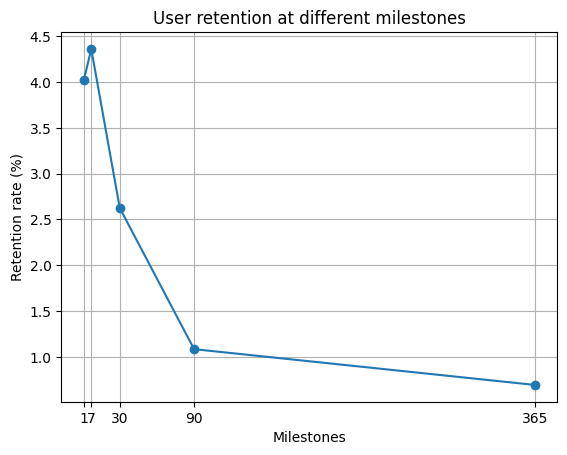

In [28]:
periods = [1, 7, 30, 90, 365]
day_retention = elapsed_days_count[elapsed_days_count["elapsed_days"].isin(periods)]

plt.plot(day_retention["elapsed_days"], day_retention["percentage"], marker='o')
plt.title("User retention at different milestones")
plt.xlabel('Milestones')
plt.ylabel('Retention rate (%)')
plt.xticks(periods)
plt.grid(True)
plt.show()